<a href="https://colab.research.google.com/github/livio-24/TwitterSentimentAnalysis/blob/main/TwitterSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install torch torchvision torchaudio


In [5]:
!pip install kaggle

Upload your kaggle.json file

In [6]:
#configuring the path of Kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Importing twitter sentiment dataset from kaggle through API

In [7]:
!kaggle datasets download -d kazanova/sentiment140

 74% 60.0M/80.9M [00:00<00:00, 233MB/s]
100% 80.9M/80.9M [00:00<00:00, 217MB/s]


In [8]:
#extracting compressed dataset
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset, 'r') as zips:
  zips.extractall()
  print('dataset extracted')

dataset extracted


Importing dependencies

In [55]:
import numpy as np
import pandas as pd
import re
import torch

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB


# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [10]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [11]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Exploring dataset

In [12]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', names = DATASET_COLUMNS, encoding = 'ISO-8859-1')

In [13]:
twitter_data.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
twitter_data.shape

(1600000, 6)

In [15]:
twitter_data['sentiment'].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

<ipython-input-16-69a712079065>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_data['sentiment'] = twitter_data['sentiment'].replace(4,1)


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

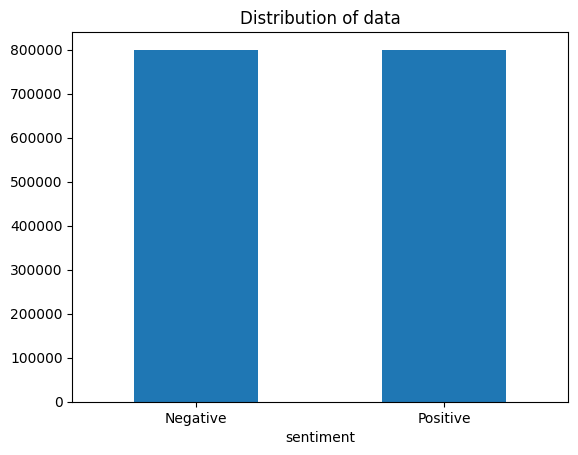

In [16]:
# Removing the unnecessary columns.
twitter_data = twitter_data[['sentiment','text']]
# Replacing the values to ease understanding.
twitter_data['sentiment'] = twitter_data['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = twitter_data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
#text, sentiment = list(twitter_data['text']), list(twitter_data['sentiment'])

0 = negative
1 = positive

The dataset is balanced

In [17]:
twitter_data.isnull().sum()

sentiment    0
text         0
dtype: int64

No missing values

Text pre-processing

In [18]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [19]:
# Abbreviations and/or slangs
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [62]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [63]:
def convert_abbrev_in_text(text):
    tokens = text.split()
    tokens=[convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [22]:
'''
def lemmatize_words_in_text(text):
    wnl = WordNetLemmatizer()
    tokens = word_tokenize(text)
    words = []
    for word, tag in pos_tag(tokens):
      print(word, tag[0])
      wntag = tag[0].lower()
      wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    # Checking if the word is a stopword. if word not in stopwordlist:
      if not word in stopwords.words('english'):
        lemma = wnl.lemmatize(word, wntag) if wntag else word
        words.append(lemma)

    text = ' '.join(words)
    return text
    '''

"\ndef lemmatize_words_in_text(text):\n    wnl = WordNetLemmatizer()\n    tokens = word_tokenize(text)\n    words = []\n    for word, tag in pos_tag(tokens):\n      print(word, tag[0])\n      wntag = tag[0].lower()\n      wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None\n    # Checking if the word is a stopword. if word not in stopwordlist:\n      if not word in stopwords.words('english'):\n        lemma = wnl.lemmatize(word, wntag) if wntag else word\n        words.append(lemma)\n\n    text = ' '.join(words)\n    return text\n    "

In [64]:
def stemming(text):
    port_stem = PorterStemmer()
    #tokens = word_tokenize(text)
    # Checking if the word is a stopword. if word not in stopwordlist:
    tokens=[port_stem.stem(word) for word in text.split() if not word in stopwords.words('english') and len(word) > 1]
    text = ' '.join(tokens)
    return text

In [59]:
stemming(" is upset that can t update his Facebook by texting it... and might cry as a result  School today also. Blah!")

'upset updat facebook text it... might cri result school today also. blah!'

In [67]:
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer.
    #wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' ',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' ', tweet)
        # Replace abbreviations/slangs
        tweet = convert_abbrev_in_text(tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        # stemming words, removing stopwords
        tweet = stemming(tweet)
        '''
        tweetwords = ''
        #todo, pos tagging before lemmatize
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if not word in stopwords.words('english'):
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
        '''
        processedText.append(tweet)

    return processedText

In [39]:
preprocess(["is upset that he can't update his Facebook by"])


['upset can t updat facebook']

In [68]:
%%time
import time
processedtext = preprocess(twitter_data['text'])

CPU times: user 31min 18s, sys: 3min 44s, total: 35min 2s
Wall time: 35min 1s


Word Cloud negative tweets

In [69]:
np.save('/content/drive/MyDrive/processedtext2.npy', processedtext)

In [70]:
#I saved processed text on drive
processedtext = list(np.load('/content/drive/MyDrive/processedtext2.npy'))

In [71]:
#add cleaned text as new column
twitter_data['clean_text'] = processedtext

In [72]:
twitter_data.head()

,sentiment,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww bummer shoulda got david carr third day em...
1,0,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save 50 rest go bound
3,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",behav mad see


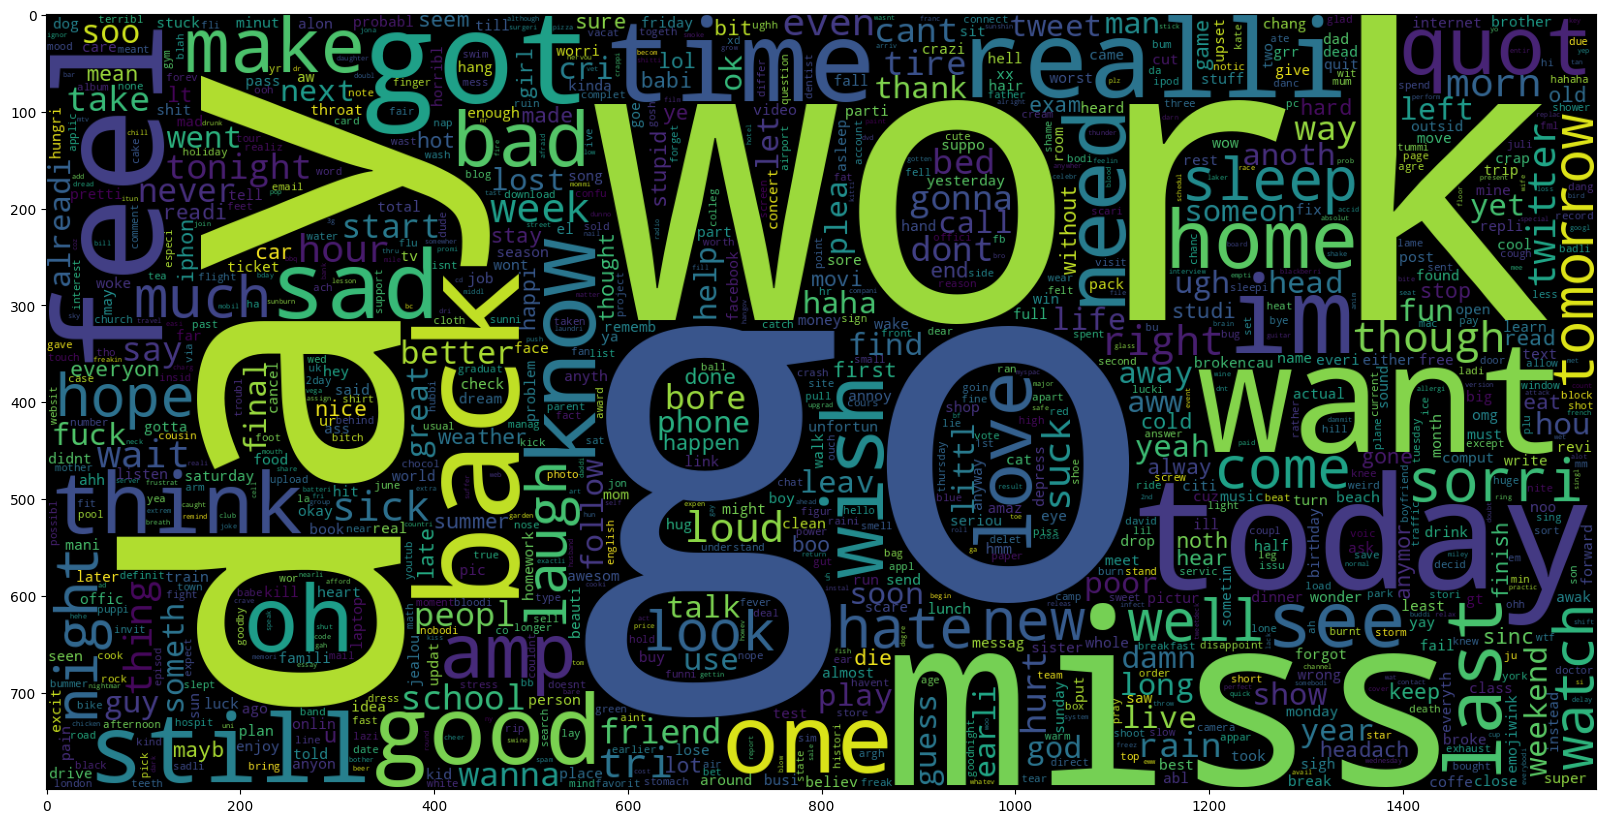

In [73]:
data_neg = twitter_data[twitter_data['sentiment'] == 0]['clean_text']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Word cloud positive tweets

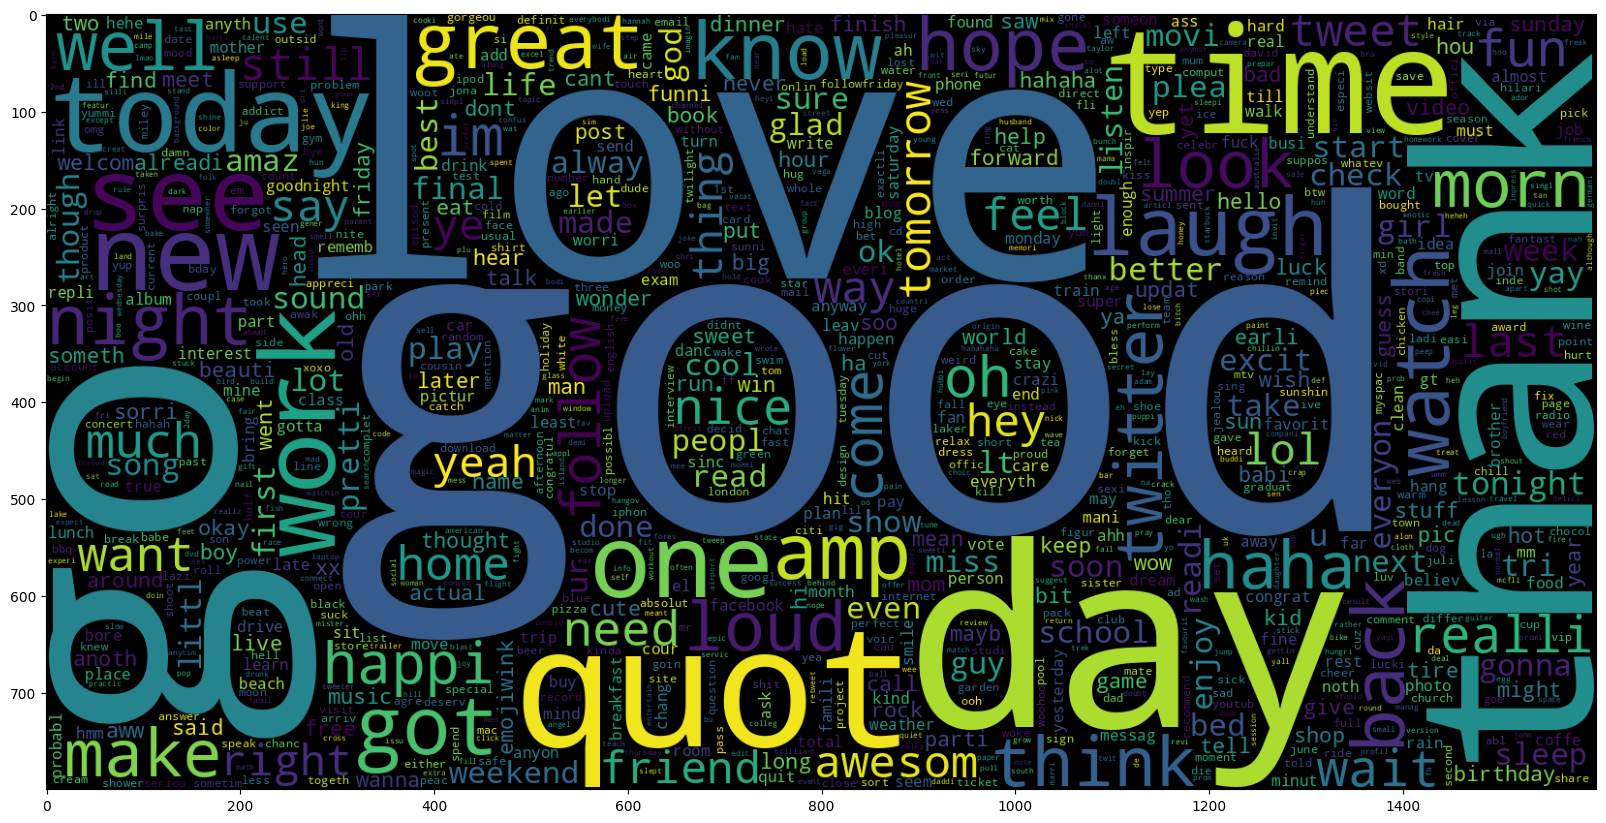

In [74]:
data_pos = twitter_data[twitter_data['sentiment'] == 1]['clean_text']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [75]:
#source of code : https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [76]:
%matplotlib inline

n-grams analysis

In [77]:
import plotly.graph_objects as go

pos_unigrams = get_top_n_words(twitter_data[twitter_data['sentiment'] == 1]['clean_text'],20)
neg_unigrams = get_top_n_words(twitter_data[twitter_data['sentiment'] == 0]['clean_text'],20)

df1 = pd.DataFrame(pos_unigrams, columns = ['Text' , 'count'])
df2 = pd.DataFrame(neg_unigrams, columns = ['Text' , 'count'])
#df1

# Create a horizontal bar plot
fig = go.Figure()

fig.add_trace(go.Bar(
    y=df1['Text'],
    x=df1['count'],
    orientation='h',
    marker=dict(color='red'),
))

fig.update_layout(
    title='Top 20 Unigrams in positive text',
    xaxis=dict(title='Count'),
    yaxis=dict(title='Text'),
    bargap=0.2,  # Adjust the gap between bars
)

# Show the plot
fig.show()

# Create a horizontal bar plot
fig = go.Figure()

fig.add_trace(go.Bar(
    y=df2['Text'],
    x=df2['count'],
    orientation='h',
    marker=dict(color='red'),
))

fig.update_layout(
    title='Top 20 Unigrams in negative text',
    xaxis=dict(title='Count'),
    yaxis=dict(title='Text'),
    bargap=0.2,  # Adjust the gap between bars
)

#df2.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
 #   kind='bar', yTitle='Count', linecolor='black', color='green',title='Top 20 Unigrams in negative text',orientation='h')

bigrams

In [78]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [79]:
import plotly.graph_objects as go

pos_bigrams = get_top_n_gram(twitter_data[twitter_data['sentiment'] == 1]['clean_text'],(2,2), 20)
neg_bigrams = get_top_n_gram(twitter_data[twitter_data['sentiment'] == 0]['clean_text'], (2,2), 20)

df1 = pd.DataFrame(pos_bigrams, columns = ['Text' , 'count'])
df2 = pd.DataFrame(neg_bigrams, columns = ['Text' , 'count'])
#df1

# Create a horizontal bar plot
fig = go.Figure()

fig.add_trace(go.Bar(
    y=df1['Text'],
    x=df1['count'],
    orientation='h',
    marker=dict(color='red'),
))

fig.update_layout(
    title='Top 20 Bigrams in positive text',
    xaxis=dict(title='Count'),
    yaxis=dict(title='Text'),
    bargap=0.2,  # Adjust the gap between bars
)

# Show the plot
fig.show()

# Create a horizontal bar plot
fig = go.Figure()

fig.add_trace(go.Bar(
    y=df2['Text'],
    x=df2['count'],
    orientation='h',
    marker=dict(color='red'),
))

fig.update_layout(
    title='Top 20 Bigrams in negative text',
    xaxis=dict(title='Count'),
    yaxis=dict(title='Text'),
    bargap=0.2,  # Adjust the gap between bars
)

Dataset split

In [137]:
# Assuming X is your feature matrix and y is your target variable
X_train, X_temp, y_train, y_temp = train_test_split(twitter_data['clean_text'], twitter_data['sentiment'], test_size=0.3, random_state=42)

# Now, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


70% train, 15% val, 15% test

In [139]:
print(len(X_train), len(X_val), len(X_test))

1120000 240000 240000


Transforming data in numeric values with TF-IDF Vectoriser

TF-IDF indicates what the importance of the word is in order to understand the document or dataset.

TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. The Vectoriser is usually trained on only the X_train dataset.

ngram_range is the range of number of words in a sequence. [e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]

max_features specifies the number of features to consider. [Ordered by feature frequency across the corpus]

fitting the vectorizer on train data

In [141]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  500000


Transforming the dataset

In [143]:
X_train = vectoriser.transform(X_train)
X_val  = vectoriser.transform(X_val)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


Model creation and evalution

In [150]:
def model_Evaluate(model, X, y):

    # Predict values for Test dataset
    y_pred = model.predict(X)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

LogReg Best params :  {'C': 1.0, 'penalty': 'l2', 'tol': 0.0001}


In [145]:
LRmodel = LogisticRegression(max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [146]:
X_train_prediction = LRmodel.predict(X_train)
training_data_accuracy = accuracy_score(y_train, X_train_prediction)

In [152]:
print('accuracy score on training data: ', training_data_accuracy)

accuracy score on training data:  0.8324392857142857


              precision    recall  f1-score   support

           0       0.80      0.77      0.79    119454
           1       0.78      0.81      0.79    120546

    accuracy                           0.79    240000
   macro avg       0.79      0.79      0.79    240000
weighted avg       0.79      0.79      0.79    240000



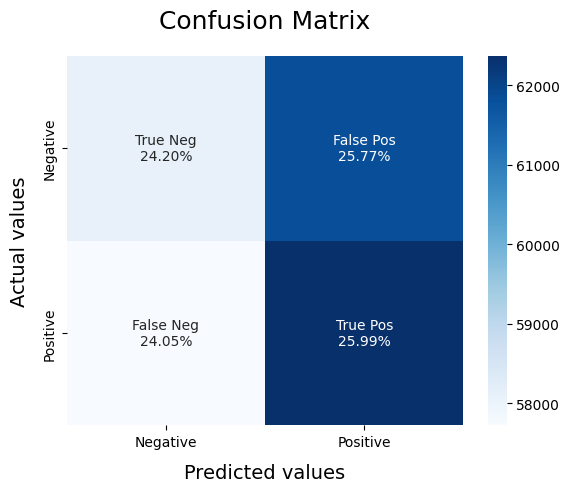

In [151]:
model_Evaluate(LRmodel, X_val, y_val)

SVC Best params : {'C': 0.1, 'penalty': 'l2', 'tol': 0.001}

LinearSVC Model

In [169]:
SVCmodel = LinearSVC(C = 0.1, tol = 0.0001)
SVCmodel.fit(X_train, y_train)


LinearSVC(C=0.1)

In [170]:
X_train_prediction = SVCmodel.predict(X_train)
training_data_accuracy = accuracy_score(y_train, X_train_prediction)

In [171]:
print('accuracy score on training data: ', training_data_accuracy)

accuracy score on training data:  0.8335642857142858


              precision    recall  f1-score   support

           0       0.80      0.77      0.79    119454
           1       0.78      0.81      0.79    120546

    accuracy                           0.79    240000
   macro avg       0.79      0.79      0.79    240000
weighted avg       0.79      0.79      0.79    240000



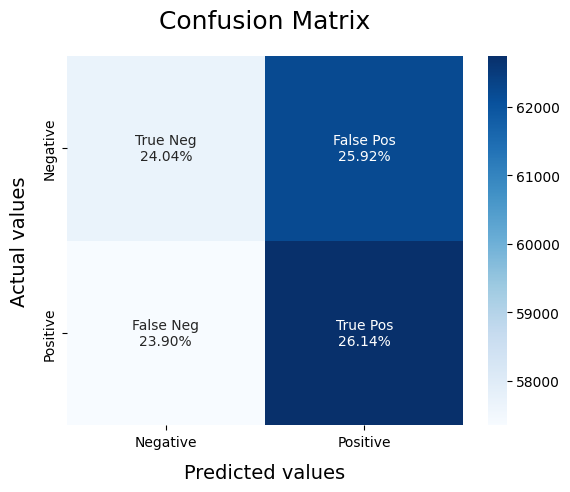

In [172]:
model_Evaluate(SVCmodel, X_val, y_val)

Bernoulli Naive Bayes

In [178]:
BNBmodel = BernoulliNB(alpha = 1)
BNBmodel.fit(X_train, y_train)


BernoulliNB(alpha=1)

In [179]:
X_train_prediction = BNBmodel.predict(X_train)
training_data_accuracy = accuracy_score(y_train, X_train_prediction)

In [180]:
print('accuracy score on training data: ', training_data_accuracy)

accuracy score on training data:  0.8252357142857143


              precision    recall  f1-score   support

           0       0.79      0.75      0.77    119454
           1       0.76      0.80      0.78    120546

    accuracy                           0.77    240000
   macro avg       0.78      0.77      0.77    240000
weighted avg       0.78      0.77      0.77    240000



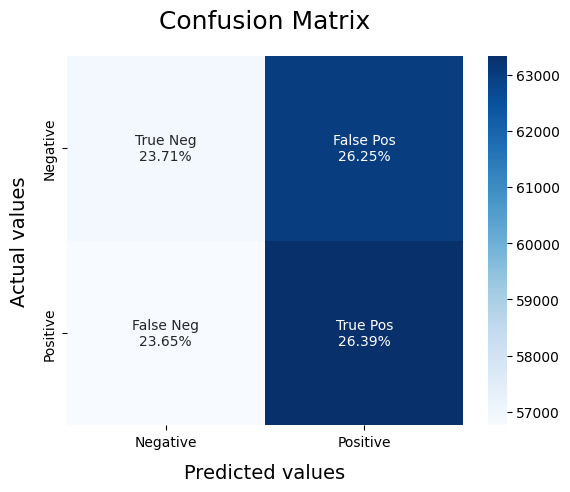

In [181]:
model_Evaluate(BNBmodel, X_val, y_val)

EVALUATING LOGISTIC REGRESSION MODEL ON TEST SET

              precision    recall  f1-score   support

           0       0.80      0.77      0.79    119907
           1       0.78      0.81      0.79    120093

    accuracy                           0.79    240000
   macro avg       0.79      0.79      0.79    240000
weighted avg       0.79      0.79      0.79    240000



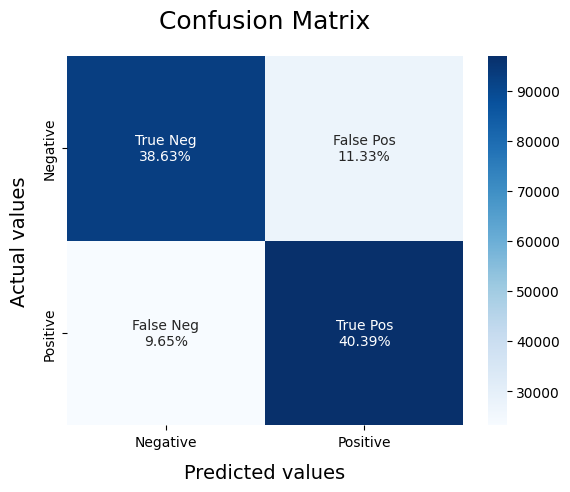

In [182]:
model_Evaluate(LRmodel, X_test, y_test)

Hyper-parameters tuning

Gread search

In [162]:
from sklearn.model_selection import GridSearchCV

In [163]:
%%time
param_grid = { "C" : [0.01, 0.1, 1.0, 10],
               "tol" : [1e-4, 1e-3]}

grid = GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=-1), param_grid)
grid.fit(X_train, y_train)


CPU times: user 25 s, sys: 9.94 s, total: 35 s
Wall time: 47min 12s


GridSearchCV(estimator=LogisticRegression(max_iter=1000, n_jobs=-1),
             param_grid={'C': [0.01, 0.1, 1.0, 10], 'tol': [0.0001, 0.001]})

In [164]:
print("Best params : ", grid.best_params_)

Best params :  {'C': 1.0, 'tol': 0.0001}


LogReg Best params :  {'C': 1.0, 'tol': 0.0001}



In [165]:
%%time

param_grid = { "C" : [0.01, 0.1, 1.0, 10],
               "tol" : [1e-4, 1e-3]}
grid = GridSearchCV(LinearSVC(), param_grid)
grid.fit(X_train, y_train)


CPU times: user 26min 2s, sys: 7.93 s, total: 26min 10s
Wall time: 26min 3s


GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.1, 1.0, 10], 'tol': [0.0001, 0.001]})

In [166]:
print("Best params : ", grid.best_params_)

Best params :  {'C': 0.1, 'tol': 0.0001}


SVC Best params :  {'C': 0.1, 'tol': 0.0001}

In [167]:
%%time

param_grid = { "alpha" : [0.01, 0.1, 1.0, 10]}
grid = GridSearchCV(BernoulliNB(), param_grid)
grid.fit(X_train, y_train)

CPU times: user 9.83 s, sys: 1.62 s, total: 11.4 s
Wall time: 11.4 s


GridSearchCV(estimator=BernoulliNB(),
             param_grid={'alpha': [0.01, 0.1, 1.0, 10]})

In [168]:
print("Best params : ", grid.best_params_)


Best params :  {'alpha': 1.0}
